<a href="https://colab.research.google.com/github/stepan-ha/Flows/blob/master/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оптимальний портфель (за коефіцієнтом Шарпа)

Імпорт бібліотек

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
from datetime import datetime

Ініціалізація Даних

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA']
start_date = '2018-01-01'
end_date = '2025-10-15'
num_assets = len(tickers)
trading_days = 252


data = yf.download(tickers, start=start_date, end=end_date)
prices = data['Close'].dropna()

print(prices.tail())

/tmp/ipython-input-3353600644.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed

Ticker            AAPL        AMZN       GOOGL        MSFT        NVDA  \
Date                                                                     
2025-10-08  258.059998  225.220001  244.619995  524.849976  189.110001   
2025-10-09  254.039993  227.740005  241.529999  522.400024  192.570007   
2025-10-10  245.270004  216.369995  236.570007  510.959991  183.160004   
2025-10-13  247.660004  220.070007  244.149994  514.049988  188.320007   
2025-10-14  247.770004  216.389999  245.449997  513.570007  180.029999   

Ticker            TSLA  
Date                    
2025-10-08  438.690002  
2025-10-09  435.540009  
2025-10-10  413.489990  
2025-10-13  435.899994  
2025-10-14  429.239990  


Відображення графіків зміни цін

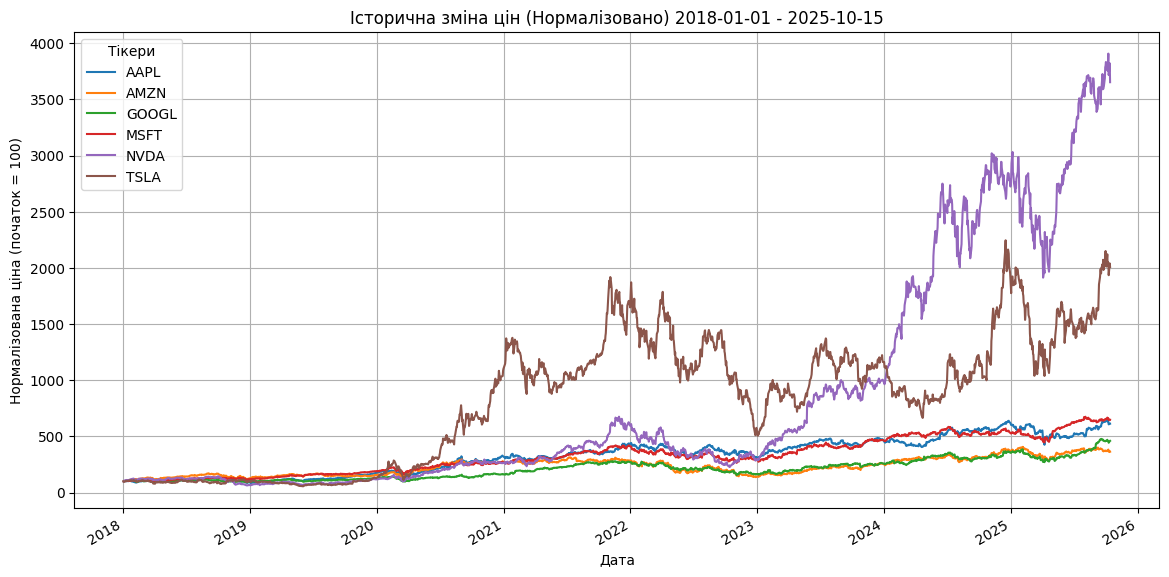

In [4]:

(prices / prices.iloc[0] * 100).plot(figsize=(14, 7))
plt.title(f'Історична зміна цін (Нормалізовано) {start_date} - {end_date}')
plt.xlabel('Дата')
plt.ylabel('Нормалізована ціна (початок = 100)')
plt.legend(title='Тікери')
plt.grid(True)
plt.show()


Дохідність (mean): 0.4925
Волатильність (std dev): 0.3914
Коефіцієнт Шарпа: 1.2584
Ваги портфеля:
  AAPL: 0.0641
  MSFT: 0.0108
  GOOGL: 0.0245
  AMZN: 0.2235
  TSLA: 0.4581
  NVDA: 0.2191
Дохідність (mean): 0.4864
Волатильність (std dev): 0.3854
Коефіцієнт Шарпа: 1.2619
Ваги портфеля:
  AAPL: 0.1198
  MSFT: 0.0000
  GOOGL: 0.0000
  AMZN: 0.2276
  TSLA: 0.4429
  NVDA: 0.2098


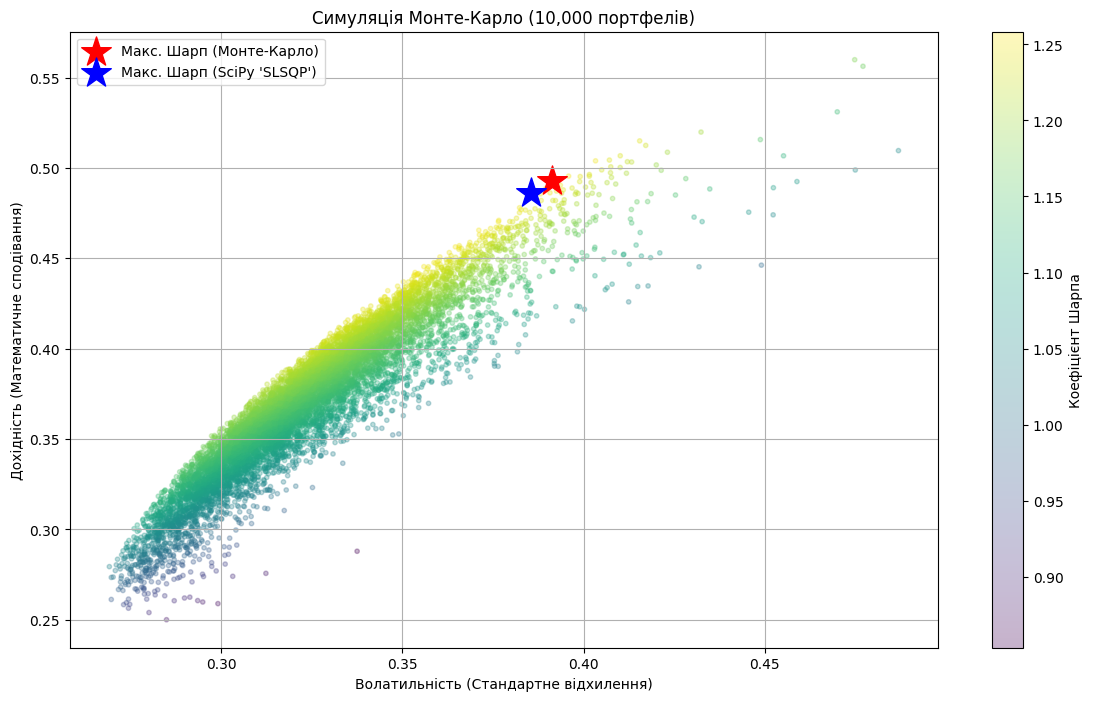

In [5]:
daily_returns = prices.pct_change().dropna()

mean_daily_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

num_portfolios = 10000

results = np.zeros((3 + num_assets, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    port_return = np.sum(mean_daily_returns * weights) * trading_days
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * trading_days, weights)))
    port_sharpe = port_return / port_volatility
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = port_sharpe
    for j in range(num_assets):
        results[j+3, i] = weights[j]

results_df = pd.DataFrame(results.T, columns=['return', 'volatility', 'sharpe'] + [f'w_{t}' for t in tickers])

max_sharpe_port_mc = results_df.loc[results_df['sharpe'].idxmax()]

print(f"Дохідність (mean): {max_sharpe_port_mc['return']:.4f}")
print(f"Волатильність (std dev): {max_sharpe_port_mc['volatility']:.4f}")
print(f"Коефіцієнт Шарпа: {max_sharpe_port_mc['sharpe']:.4f}")
print("Ваги портфеля:")
for ticker in tickers:
    print(f"  {ticker}: {max_sharpe_port_mc[f'w_{ticker}']:.4f}")

plt.figure(figsize=(14, 8))
plt.scatter(results_df['volatility'], results_df['return'], c=results_df['sharpe'], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Коефіцієнт Шарпа')
plt.title('Симуляція Монте-Карло (10,000 портфелів)')
plt.xlabel('Волатильність (Стандартне відхилення)')
plt.ylabel('Дохідність (Математичне сподівання)')

plt.scatter(max_sharpe_port_mc['volatility'], max_sharpe_port_mc['return'],
            marker='*', color='r', s=500, label='Макс. Шарп (Монте-Карло)')


def neg_sharpe_ratio(weights, mean_returns, cov_matrix, trading_days):
    port_return = np.sum(mean_returns * weights) * trading_days
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * trading_days, weights)))
    if port_volatility == 0:
        return 0
    return -(port_return / port_volatility)

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

bounds = tuple((0, 1) for _ in range(num_assets))

initial_weights = np.array([1 / num_assets] * num_assets)

opt_result = sco.minimize(neg_sharpe_ratio,
                            initial_weights,
                            args=(mean_daily_returns, cov_matrix, trading_days),
                            method='SLSQP',
                            bounds=bounds,
                            constraints=constraints)

opt_weights = opt_result.x
opt_return = np.sum(mean_daily_returns * opt_weights) * trading_days
opt_volatility = np.sqrt(np.dot(opt_weights.T, np.dot(cov_matrix * trading_days, opt_weights)))
opt_sharpe = -opt_result.fun

print(f"Дохідність (mean): {opt_return:.4f}")
print(f"Волатильність (std dev): {opt_volatility:.4f}")
print(f"Коефіцієнт Шарпа: {opt_sharpe:.4f}")
print("Ваги портфеля:")
for i, ticker in enumerate(tickers):
    print(f"  {ticker}: {opt_weights[i]:.4f}")

plt.scatter(opt_volatility, opt_return,
            marker='*', color='b', s=500, label="Макс. Шарп (SciPy 'SLSQP')")

plt.legend()
plt.grid(True)
plt.show()